# Prepare notebook

In [1]:
!pip install gdown -q

In [2]:
!gdown 18KIvMBWD031oDvg0DVebI06SMwKuTp4l -O sh3_sc6_y32_x32_imgs.npz

Downloading...
From (original): https://drive.google.com/uc?id=18KIvMBWD031oDvg0DVebI06SMwKuTp4l
From (redirected): https://drive.google.com/uc?id=18KIvMBWD031oDvg0DVebI06SMwKuTp4l&confirm=t&uuid=e433433c-a578-4354-9ab6-113426386ef9
To: /kaggle/working/sh3_sc6_y32_x32_imgs.npz
100%|███████████████████████████████████████| 75.5M/75.5M [00:00<00:00, 282MB/s]


In [3]:
!pip install -q pytorch_fid

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

import gc

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


### Constants-Globs

In [6]:
DATA_PATH = './sh3_sc6_y32_x32_imgs.npz'
TRAIN_RATIO = 0.8

LATENT_DIM = 256
Z_DIM = 10

BETA_1 = 0.9
BETA_2 = 0.99
LEARNING_RATE = 1e-4

BATCH_SIZE = 128
TRAIN_EPOCHS = 100

## Data

In [7]:
scale = transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))

class DspritesDataset(Dataset):

    def __init__(self, npz_path, transform=None):
        data = np.load(npz_path, allow_pickle=True, encoding='latin1')
        self.transform = transform
        self.images = data['imgs']

        if self.transform is None:
          self.transform = transforms.Compose([
              transforms.ToTensor(),
              transforms.Lambda(lambda x: (x > 0).float()),
              scale,
          ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = self.transform(image)
        return image


In [8]:
dataset = DspritesDataset(DATA_PATH)
print(len(dataset))

18432


In [9]:
train_size = int(TRAIN_RATIO * len(dataset))
test_size = len(dataset) - train_size
lengths = [train_size, test_size]

train_dataset, test_dataset = random_split(dataset, lengths)

In [10]:
print(f'Train size: {len(train_dataset)}')
print(f'Test size: {len(test_dataset)}')

Train size: 14745
Test size: 3687


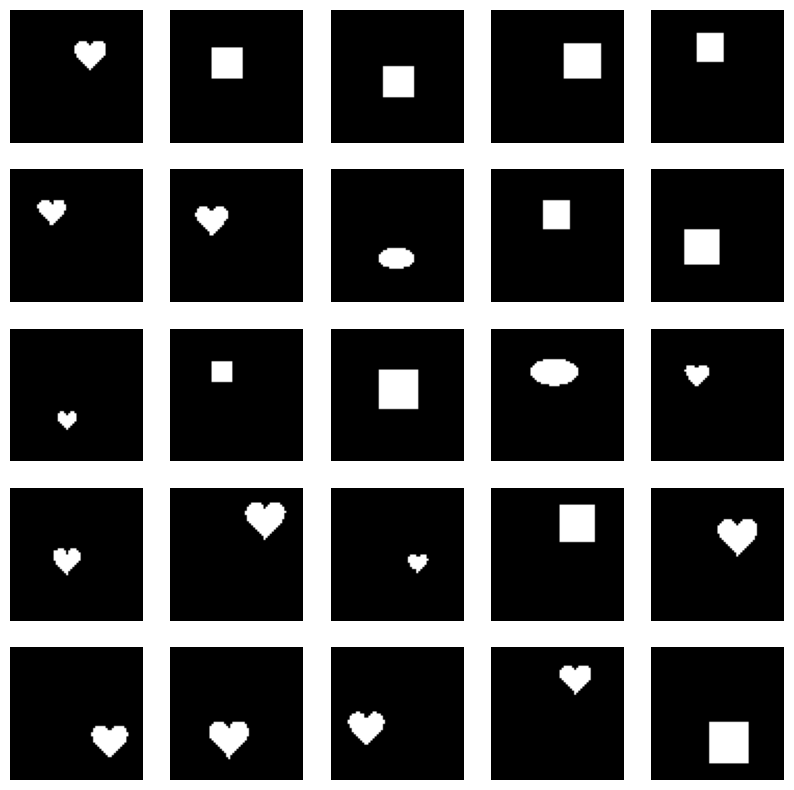

In [11]:
import random

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    idx = random.randint(0, len(train_dataset)-1)
    plt.imshow(train_dataset[idx].squeeze(), cmap='gray')
    plt.axis('off')

## VariationalAutoEncoder Model

In [12]:
def reparameterize(mu, sigma):
    std = torch.exp(sigma / 2.)
    eps = torch.randn_like(mu).to(mu.get_device())
    return mu + std * eps


class VAE(nn.Module):
    def __init__(self, latent_dim, z_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=latent_dim, kernel_size=4, stride=1),
            nn.ReLU(),
        )
        self.fc_encoder = nn.Linear(latent_dim, latent_dim)
        self.fc_mu = nn.Linear(latent_dim, z_dim)
        self.fc_sigma = nn.Linear(latent_dim, z_dim)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=latent_dim, out_channels=64, kernel_size=4),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=4, stride=2, padding=1),
        )
        self.fc_decoder = nn.Linear(z_dim, latent_dim)

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(-1, self.latent_dim)
        h = self.fc_encoder(h)
        mu = self.fc_mu(h)
        sigma = self.fc_sigma(h)
        return h, mu, sigma

    def decode(self, z):
        h = self.fc_decoder(z)
        h = h.view(-1, 256, 1, 1)
        x = self.decoder(h)
        x = F.sigmoid(x)
        return x

    def forward(self, x):
        _, mu, sigma = self.encode(x)
        z = reparameterize(mu, sigma)
        x = self.decode(z)
        return x, mu, sigma


## Train utils

In [13]:
def kl_divergence(mu, sigma):
    return (-0.5 * (1 + sigma - mu.pow(2) - sigma.exp())).sum(dim=1).mean()

In [14]:
def reconstruction_loss(x, x_hat):
    batch_size = x.size(0)
    return F.mse_loss(x_hat, x, reduction='sum')
    # return F.binary_cross_entropy_with_logits(x_hat, x, reduction='sum') / batch_size

In [15]:
@torch.no_grad()
def model_eval(model, loader, criterion):
  """Returns total_loss, reconstruction loss, kld_loss"""
  total_loss = 0.0
  rec_loss = 0.0
  kl_loss = 0.0
  total_samples = 0

  model.eval()
  itr = tqdm(loader, total=len(loader), leave=False)

  for batch in itr:
      total_samples += len(batch)
      batch = batch.to(DEVICE)

      _x, _mu, _sigma = model(batch)

      kl = kl_divergence(_mu, _sigma)
      kl_loss += kl.item()
      rec = reconstruction_loss(batch, _x)
      rec_loss += rec.item()

      loss = criterion(batch, _x, _mu, _sigma)
      total_loss += loss.item()


      itr.set_description("(Eval)")
      itr.set_postfix(
          total_loss=round(total_loss/total_samples, 4),
          kd_div=round(kl_loss/total_samples, 4),
          rec_loss=round(rec_loss/total_loss, 4),
      )

  total_loss = total_loss / total_samples
  rec_loss = rec_loss / total_samples
  kl_loss = kl_loss / total_samples

  return total_loss, rec_loss, kl_loss


In [16]:
def train_model(
        model,
        batch_size,
        epochs,
        train_set,
        test_set,
        lr=2e-5,
        use_PI=False,
        pi_kw_args={},
):
  train_total_losses = []
  test_total_losses = []

  train_kl_losses = []
  test_kl_losses = []

  train_rec_losses = []
  test_rec_losses = []

  if use_PI:
      assert 'des_kl' in pi_kw_args, "des_kl is required for PI"
      assert 'kp' in pi_kw_args, "kp is required for PI"
      assert 'ki' in pi_kw_args, "ki is required for PI"
      PI = PIDControl(**pi_kw_args)

  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False)

  optimizer = optim.Adam(model.parameters(), lr=lr, betas=(BETA_1, BETA_2))
  w_kl = 1.0
  criterion = lambda x, x_hat, mu, sigma: reconstruction_loss(x, x_hat) + w_kl * kl_divergence(mu, sigma)

  itr = tqdm(train_loader, total=len(train_loader), leave=False)

  for epoch in range(epochs):
      model.train()
      epoch_total_loss = 0
      epoch_kl_loss = 0
      epoch_rec_loss = 0
      epoch_samples = 0
      for batch in itr:
          epoch_samples += len(batch)
          batch = batch.to(DEVICE)

          _x, _mu, _sigma = model(batch)

          kl_loss = kl_divergence(_mu, _sigma)
          rec_loss = reconstruction_loss(batch, _x)

          loss = criterion(batch, _x, _mu, _sigma)
          epoch_total_loss += loss.item()

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          epoch_kl_loss += kl_loss.item()
          epoch_rec_loss += rec_loss.item()

          itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
          itr.set_postfix(
            loss=round(epoch_total_loss/epoch_samples, 5),
          )
          if use_PI:
            w_kl = PI.pid(kl_div=rec_loss.item())

      train_total_losses.append(epoch_total_loss/epoch_samples)
      train_kl_losses.append(epoch_kl_loss/epoch_samples)
      train_rec_losses.append(epoch_rec_loss/epoch_samples)


      model.eval()
      test_total_loss, test_rec_loss, test_kl_loss = model_eval(
          model=model,
          loader=test_loader,
          criterion=criterion,
      )
      test_total_losses.append(test_total_loss)
      test_kl_losses.append(test_kl_loss)
      test_rec_losses.append(test_rec_loss)


  history = {
    "Train_Total_Loss": train_total_losses,
    "Train_Rec_Loss": train_rec_losses,
    "Train_KL_Loss": train_kl_losses,

    "Test_Total_Loss": test_total_losses,
    "Test_Rec_Loss": test_rec_losses,
    "Test_KL_Loss": test_kl_losses,
  }
  return history

In [17]:
@torch.no_grad()
def reconstruct_and_plot_samples(model, dataset, n=5):
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
    model.eval()
    batch = iter(loader).__next__().to(DEVICE)
    x_hat, *_ = model(batch)

    plt.figure(figsize=(4*n, 6))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(batch[i][0].detach().cpu(), cmap='gray')
        plt.title("Original")
        plt.axis('off')
        plt.subplot(2, n, i+1+n)
        plt.imshow(x_hat[i][0].detach().cpu(), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    plt.show()

In [18]:
def trend_plot_helper(pobj):
    plt.figure(figsize=(8*len(pobj), 6))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, trend in plots:
            plt.plot(range(1, len(trend)+1), trend, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.legend()

## FID utils

In [19]:
import shutil
from torch.utils.data import SubsetRandomSampler

TOTAL_SAMPLES = 5000
ORIGINAL_DIR = 'original_samples'
GENERATED_DIR = 'generated_samples'

num_test_samples = min(3500, len(test_dataset))
num_train_samples = TOTAL_SAMPLES - num_test_samples
to_pil = transforms.ToPILImage()

train_indices = np.random.choice(len(train_dataset), num_train_samples, replace=False)
train_sampler = SubsetRandomSampler(train_indices)
fid_train_dataloader = DataLoader(train_dataset, batch_size=1, sampler=train_sampler)

test_indices = np.random.choice(len(test_dataset), num_test_samples, replace=False)
test_sampler = SubsetRandomSampler(test_indices)
fid_test_dataloader = DataLoader(test_dataset, batch_size=1, sampler=test_sampler)

fid_loaders = {'train': fid_train_dataloader, 'test': fid_test_dataloader}

if os.path.exists(ORIGINAL_DIR):
    shutil.rmtree(ORIGINAL_DIR)
os.mkdir(ORIGINAL_DIR)

for pre, loader in fid_loaders.items():
    for i, batch in enumerate(loader):
        path = f'{pre}_{i}.png'
        image = batch[0][0] * 255
        image = to_pil(image.byte())
        path = os.path.join(ORIGINAL_DIR, path)
        image.save(path)

In [20]:
@torch.no_grad()
def save_fid_samples(model):
    if os.path.exists(GENERATED_DIR):
        shutil.rmtree(GENERATED_DIR)
    os.mkdir(GENERATED_DIR)
    model.eval()
    for pre, loader in fid_loaders.items():
        for i, batch in enumerate(loader):
            path = f'{pre}_{i}.png'
            batch = batch.to(DEVICE)
            x_hat, *_ = model(batch)
            x_hat = torch.round(x_hat)
            image = x_hat[0][0] * 255
            image = to_pil(image.byte())
            path = os.path.join(GENERATED_DIR, path)
            image.save(path)

In [21]:
from pytorch_fid import fid_score as FID

def calculate_fid(model):
    save_fid_samples(model)
    fid_score = FID.calculate_fid_given_paths([ORIGINAL_DIR, GENERATED_DIR], batch_size=BATCH_SIZE, device=DEVICE, dims=2048)
    return fid_score

## Ordinary VAE

In [22]:
model_ovae = VAE(LATENT_DIM, Z_DIM).to(DEVICE)

In [23]:
history = train_model(
        model=model_ovae,
        batch_size=BATCH_SIZE,
        epochs=TRAIN_EPOCHS,
        train_set=train_dataset,
        test_set=test_dataset,
        lr=LEARNING_RATE,
)

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

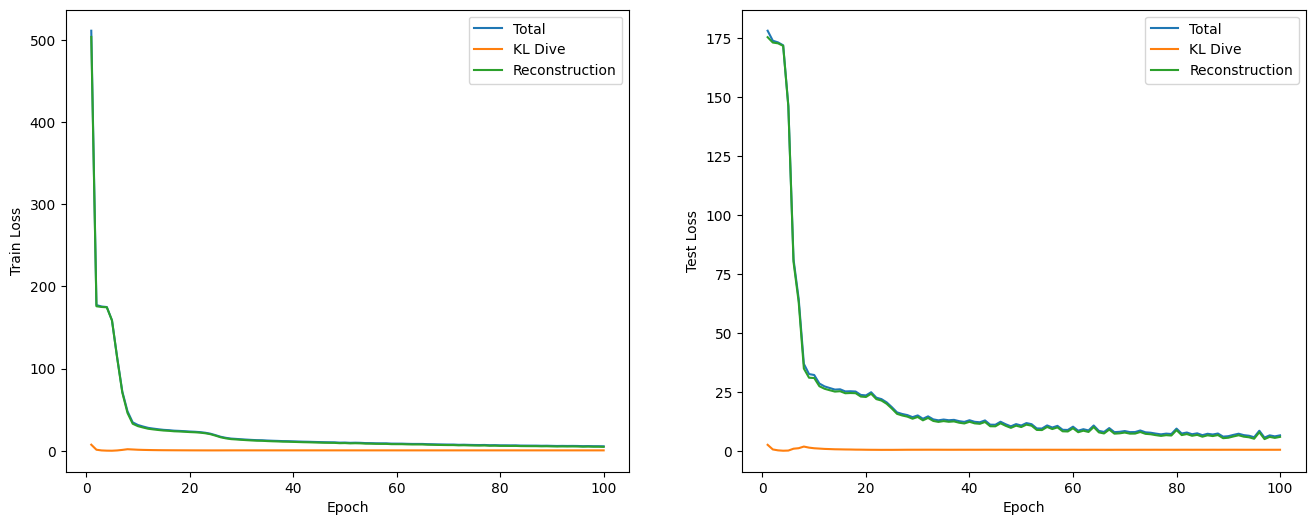

In [24]:
trend_plot_helper(
    {
        "Train Loss - Epoch": [
            ("Total", history["Train_Total_Loss"]),
            ("KL Dive", history["Train_KL_Loss"]),
            ("Reconstruction", history["Train_Rec_Loss"]),
        ],
        "Test Loss - Epoch": [
            ("Total", history["Test_Total_Loss"]),
            ("KL Dive", history["Test_KL_Loss"]),
            ("Reconstruction", history["Test_Rec_Loss"]),
        ]
    }
)

### Generate samples

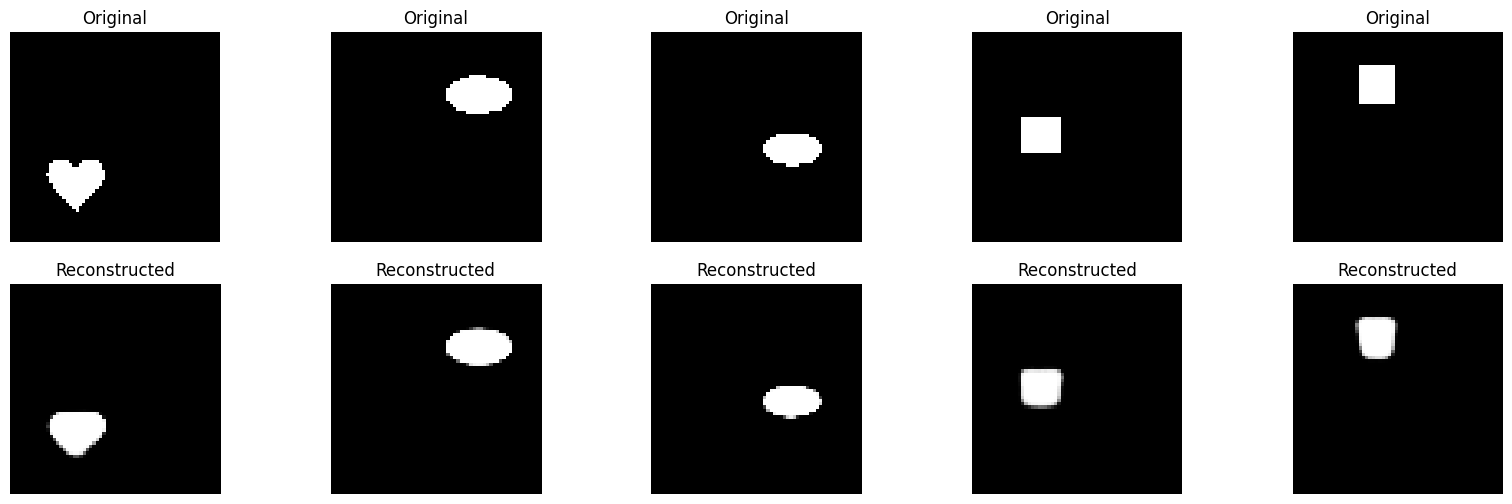

In [25]:
reconstruct_and_plot_samples(model_ovae, test_dataset)

### FID score

In [26]:
fid_score_ovae = calculate_fid(model_ovae)
print(f"FID score: {fid_score_ovae}")

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 206MB/s]
100%|██████████| 40/40 [00:18<00:00,  2.19it/s]


FID score: 14.623534108156306


In [27]:
del model_ovae
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

0

## ControlVAE

### PID Controller

In [28]:
class PIDControl:
    def __init__(self, des_kl, kp=0.001, ki=-0.001):
        self.i_k1 = 0.0
        self.w_k1 = 0.0
        
        self.des_kl = des_kl
        self.kp = kp
        self.ki = ki

    def pid(self, kl_div):
        error_k = self.des_kl - kl_div

        pk = self.kp * (1.0 / (1.0 + np.exp(error_k)))

        ik = self.i_k1
        if 0 <= self.w_k1 <= 1:
            ik = self.i_k1 - self.ki * error_k

        wk = pk + ik

        self.w_k1 = wk
        self.i_k1 = ik

        wk = np.clip(wk, 0.0, 1.0)

        return wk


### train controlVAE

In [29]:
base_conf = {
    'kp': 1e-2,
    'ki': 1e-3,
}

#### Set point = 8

In [30]:
model_pid_8 = VAE(LATENT_DIM, Z_DIM).to(DEVICE)

config_pid_8 = {
    'des_kl': 8,
    **base_conf,
}

In [31]:
history_pid_8 = train_model(
        model=model_pid_8,
        batch_size=BATCH_SIZE,
        epochs=TRAIN_EPOCHS,
        train_set=train_dataset,
        test_set=test_dataset,
        lr=LEARNING_RATE,
        use_PI=True,
        pi_kw_args=config_pid_8,
)

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

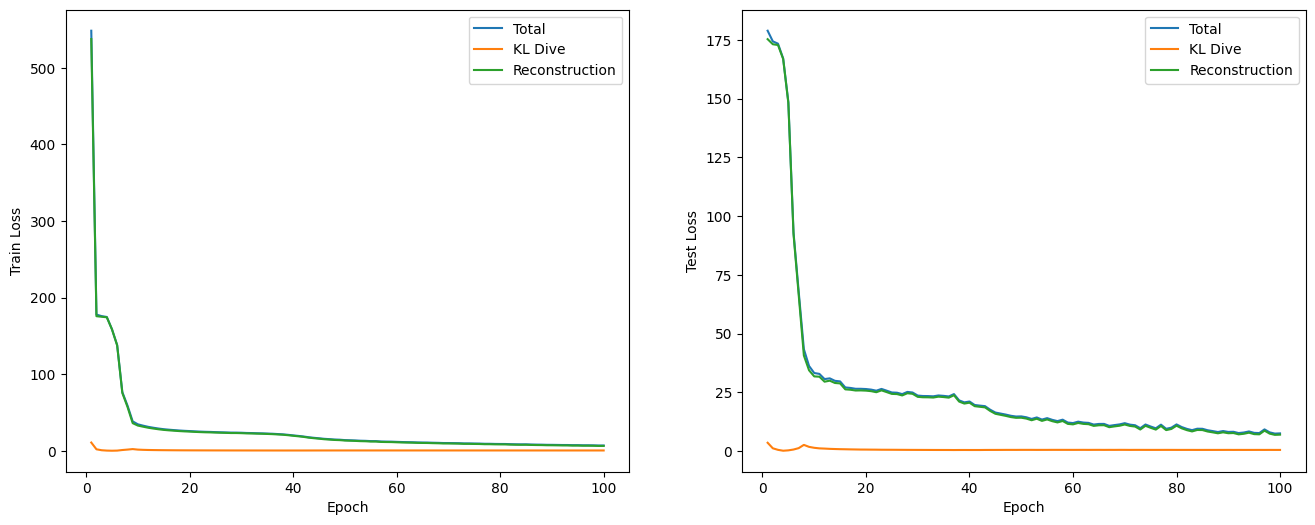

In [32]:
trend_plot_helper(
    {
        "Train Loss - Epoch": [
            ("Total", history_pid_8["Train_Total_Loss"]),
            ("KL Dive", history_pid_8["Train_KL_Loss"]),
            ("Reconstruction", history_pid_8["Train_Rec_Loss"]),
        ],
        "Test Loss - Epoch": [
            ("Total", history_pid_8["Test_Total_Loss"]),
            ("KL Dive", history_pid_8["Test_KL_Loss"]),
            ("Reconstruction", history_pid_8["Test_Rec_Loss"]),
        ]
    }
)

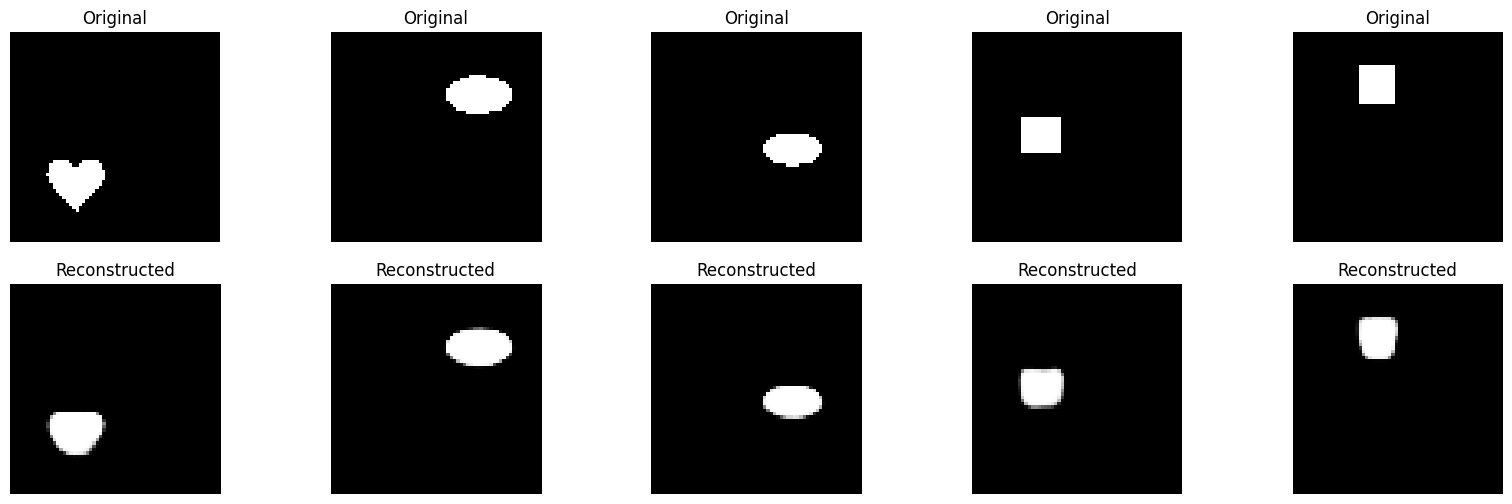

In [33]:
reconstruct_and_plot_samples(model_pid_8, test_dataset)

In [34]:
fid_score_pid_8 = calculate_fid(model_pid_8)
print(f"FID score: {fid_score_pid_8}")

100%|██████████| 40/40 [00:18<00:00,  2.19it/s]


FID score: 18.62396835676975


In [35]:
del model_pid_8
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

33820

#### Set point = 14

In [36]:
model_pid_14 = VAE(LATENT_DIM, Z_DIM).to(DEVICE)

config_pid_14 = {
    'des_kl': 14,
    **base_conf,
}

In [37]:
history_pid_14 = train_model(
        model=model_pid_14,
        batch_size=BATCH_SIZE,
        epochs=TRAIN_EPOCHS,
        train_set=train_dataset,
        test_set=test_dataset,
        lr=LEARNING_RATE,
        use_PI=True,
        pi_kw_args=config_pid_14,
)

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

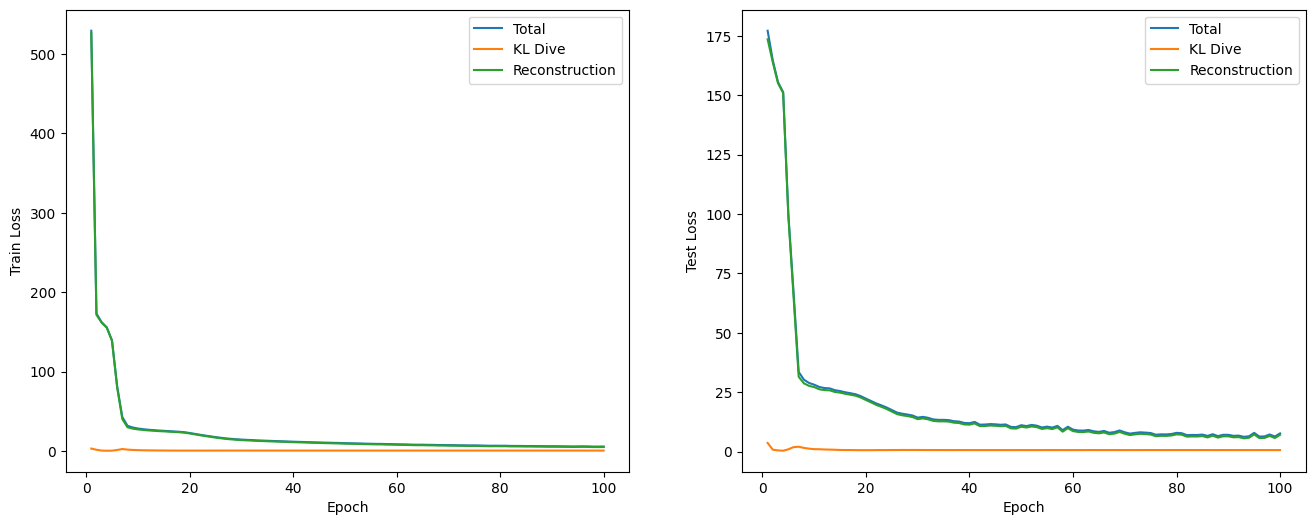

In [38]:
trend_plot_helper(
    {
        "Train Loss - Epoch": [
            ("Total", history_pid_14["Train_Total_Loss"]),
            ("KL Dive", history_pid_14["Train_KL_Loss"]),
            ("Reconstruction", history_pid_14["Train_Rec_Loss"]),
        ],
        "Test Loss - Epoch": [
            ("Total", history_pid_14["Test_Total_Loss"]),
            ("KL Dive", history_pid_14["Test_KL_Loss"]),
            ("Reconstruction", history_pid_14["Test_Rec_Loss"]),
        ]
    }
)

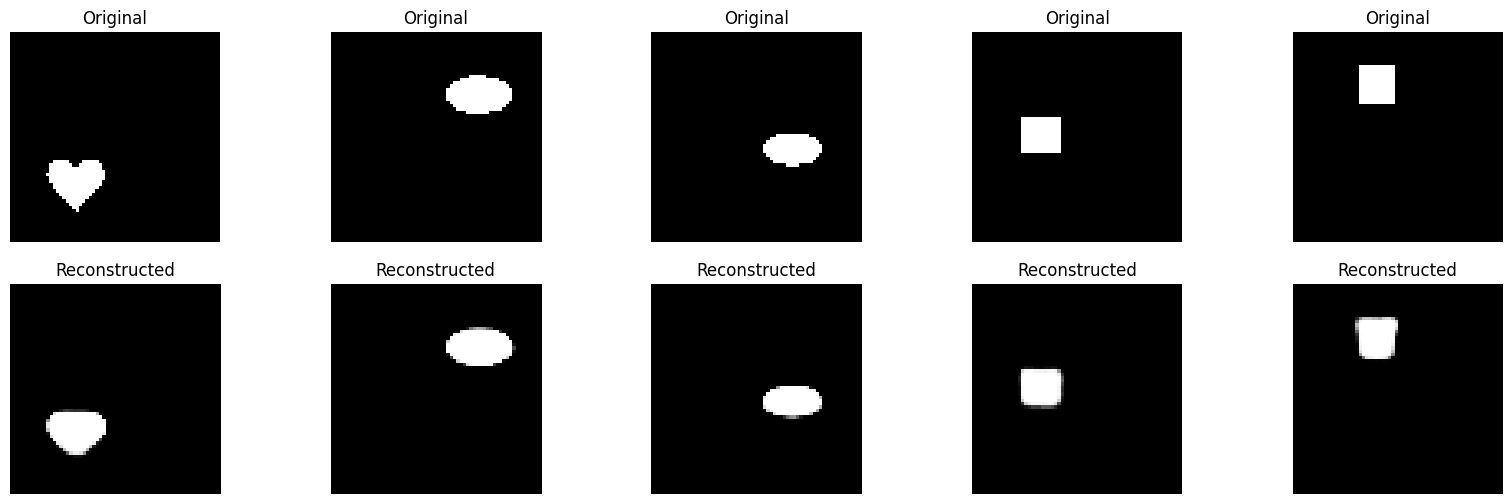

In [39]:
reconstruct_and_plot_samples(model_pid_14, test_dataset)

In [40]:
fid_score_pid_14 = calculate_fid(model_pid_14)
print(f"FID score: {fid_score_pid_14}")

100%|██████████| 40/40 [00:18<00:00,  2.19it/s]


FID score: 16.48721966410946


In [41]:
del model_pid_14
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

33830

#### Conclusion plot

we plot different loss from training on the same plot for both set points

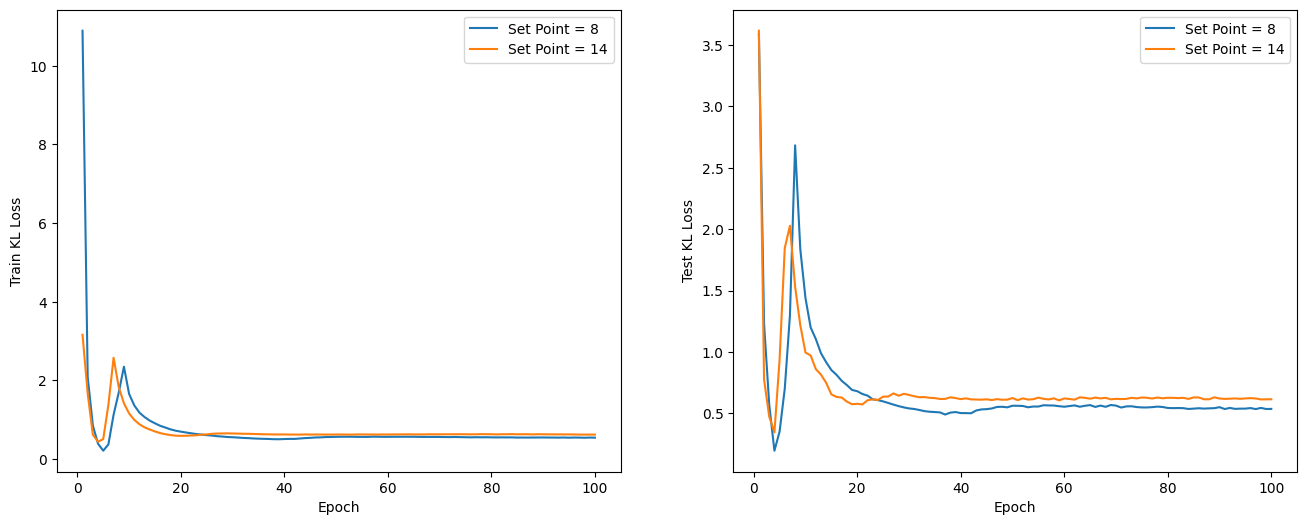

In [42]:
trend_plot_helper(
    {
        "Train KL Loss - Epoch": [
            ("Set Point = 8", history_pid_8["Train_KL_Loss"]),
            ("Set Point = 14", history_pid_14["Train_KL_Loss"]),
        ],
        "Test KL Loss - Epoch": [
            ("Set Point = 8", history_pid_8["Test_KL_Loss"]),
            ("Set Point = 14", history_pid_14["Test_KL_Loss"]),
        ]
    }
)

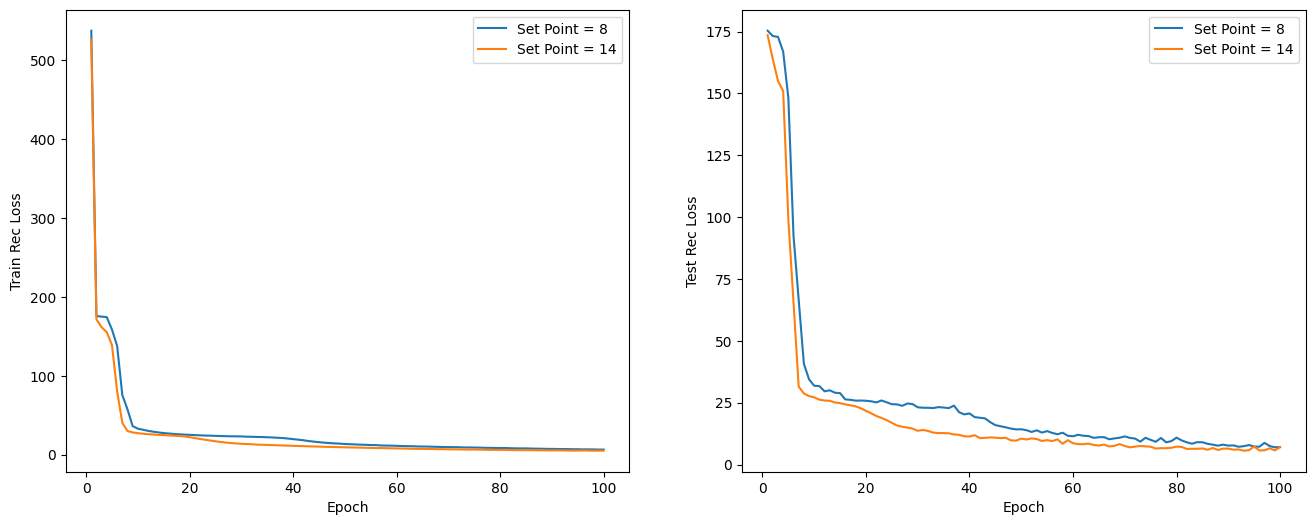

In [43]:
trend_plot_helper(
    {
        "Train Rec Loss - Epoch": [
            ("Set Point = 8", history_pid_8["Train_Rec_Loss"]),
            ("Set Point = 14", history_pid_14["Train_Rec_Loss"]),
        ],
        "Test Rec Loss - Epoch": [
            ("Set Point = 8", history_pid_8["Test_Rec_Loss"]),
            ("Set Point = 14", history_pid_14["Test_Rec_Loss"]),
        ]
    }
)

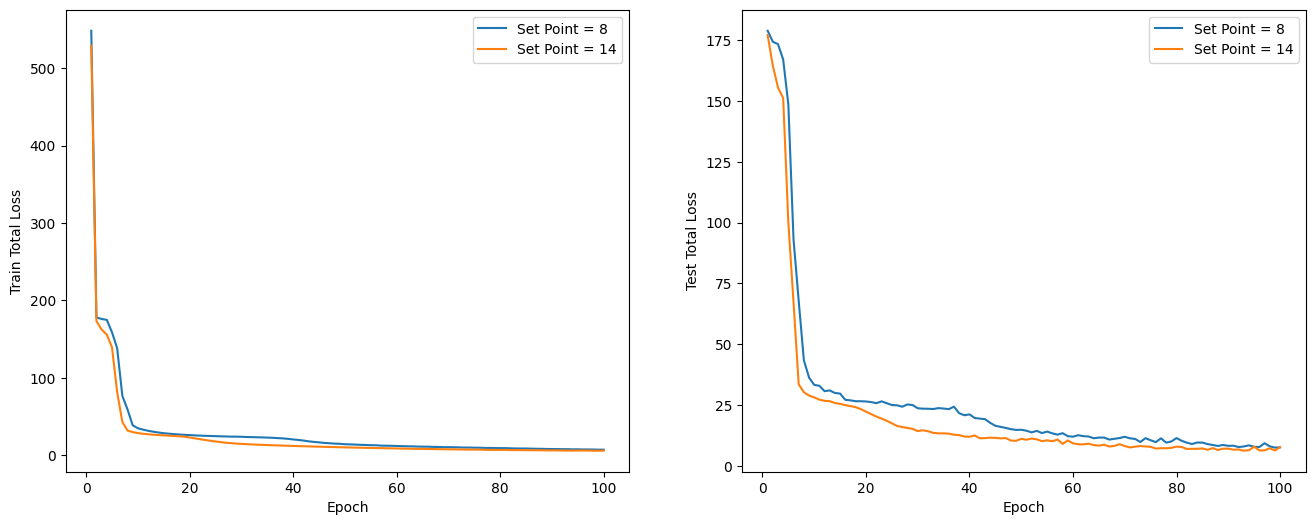

In [44]:
trend_plot_helper(
    {
        "Train Total Loss - Epoch": [
            ("Set Point = 8", history_pid_8["Train_Total_Loss"]),
            ("Set Point = 14", history_pid_14["Train_Total_Loss"]),
        ],
        "Test Total Loss - Epoch": [
            ("Set Point = 8", history_pid_8["Test_Total_Loss"]),
            ("Set Point = 14", history_pid_14["Test_Total_Loss"]),
        ]
    }
)